## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf
import optuna

import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog
tkinter.Tk().withdraw()
path=filedialog.askdirectory(title='path for whole dataset')
#date="Oct15_Same"
date="Oct15_Serial"
mask="Dataset1_bs_350_ep_150"
csv_path=3
from glob import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
#tf_device='/gpu:0'
path_gen="../"+date+"/Generator"
path_dis="../"+date+"/Discriminator"

2023-12-07 21:28:50.531976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices('GPU')

2023-12-07 21:29:03.759994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-07 21:29:03.798010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-12-07 21:29:03.798028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-07 21:29:03.798952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-12-07 21:29:03.798975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-12-07 21:29:03.799882: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 350 #350
IMAGE_SIZE=256

In [5]:
def load_data(path, split=0.05):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

In [7]:
len(train_y)

8671

In [8]:
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    
    input_image = tf.image.decode_png(image1)
   
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
        #input_image,real_image=augment(input_image,real_image)
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [9]:
def load_test(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [10]:
def load_valid(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    if(input_image.shape!=([256,256,3])):
        print(input_image.shape)
        print(256-input_image.shape[0])
        print(256-input_image.shape[1])
        input_image=tf.image.pad_to_bounding_box(input_image,0,0,256,256)
    #input_image=tf.image.resize(input_image, [256, 256],
     #                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        #real_image=tf.image.resize(real_image, [256, 256],
                       #   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

 
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [11]:
len(test_y)

481

In [12]:
def augment(input_image,real_image):
    seed=(1,2)
    tf.random.set_seed(1234)
    if tf.random.uniform(()) > 0.5:
        input_image=tf.image.stateless_random_brightness(input_image,max_delta=1.5,seed=seed)
        '''
        #input_image=tf.image.stateless_random_hue(input_image,max_delta=0.5,seed=seed)
        input_image=tf.image.stateless_random_saturation(input_image, lower=0, upper=1.5,seed=seed)

        #real_image=tf.image.random_brightness(real_image,max_delta=0.1)
        input_image = tf.image.stateless_random_contrast(input_image, lower=0, upper=1.5,seed=seed)
        #real_image = tf.image.stateless_random_contrast(real_image, lower=0.1, upper=0.9,seed=seed)
        x=tf.image.stateless_random_crop(input_image, size=(224,224,3), seed=seed)
        y=tf.image.stateless_random_crop(real_image, size=(224,224,3), seed=seed)
        real_image=tf.image.resize(y, [256, 256],
                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        input_image=tf.image.resize(x, [256, 256],
                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        input_image=tf.clip_by_value(input_image, 0, 255)
        real_image=tf.clip_by_value(real_image, 0, 255)
        input_image=tf.image.stateless_random_flip_left_right(input_image, seed=seed)
        real_image=tf.image.stateless_random_flip_up_down(real_image, seed=seed)
        '''
    return input_image,real_image

In [13]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.map(load_train)
#train_dataset=train_dataset.map(augment)
train_dataset=train_dataset.batch(BATCH_SIZE)
valid_dataset=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
valid_dataset=valid_dataset.map(load_test)
valid_dataset=valid_dataset.batch(1)
test_dataset=tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset=test_dataset.map(load_test)
test_dataset=test_dataset.batch(1)

2023-12-07 21:29:07.378370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 21:29:07.399282: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699900000 Hz
2023-12-07 21:29:07.400104: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ef6acaa400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-07 21:29:07.400126: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-07 21:29:07.459912: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ef6d57e420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-0

In [14]:
inp,re=load_train(train_x[10],train_y[10])

2023-12-07 21:29:08.505232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


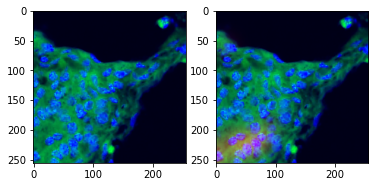

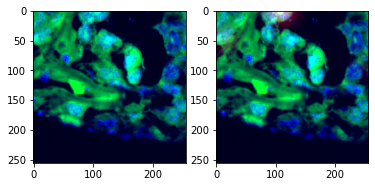

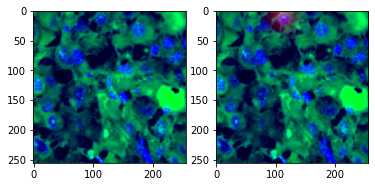

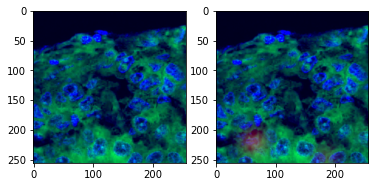

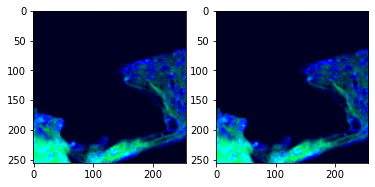

In [15]:
for x,y in train_dataset.take(1):
    #
    # print(x.shape[0])
    for i in range(5):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x[i]*0.5+0.5)
        print(tf.reduce_max(x[i]))
        print(tf.reduce_min(x[i]))
        plt.subplot(1,2,2)
        plt.imshow(y[i]*0.5+0.5)
        print(tf.reduce_max(y[i]))
        print(tf.reduce_min(y[i]))

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [16]:
OUTPUT_CHANNELS = 3

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2023-12-07 21:29:11.085707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1, 128, 128, 3)


2023-12-07 21:29:11.759043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [21]:
def Generator():
  size=4
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, size, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128,size), # (bs, 64, 64, 128)
    downsample(256, size), # (bs, 32, 32, 256)
    downsample(512, size), # (bs, 16, 16, 512)
    downsample(512, size), # (bs, 8, 8, 512)
    downsample(512, size), # (bs, 4, 4, 512)
    downsample(512, size), # (bs, 2, 2, 512)
    downsample(512, size), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, size, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, size), # (bs, 16, 16, 1024)
    upsample(256, size), # (bs, 32, 32, 512)
    upsample(128, size), # (bs, 64, 64, 256)
    upsample(64, size), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

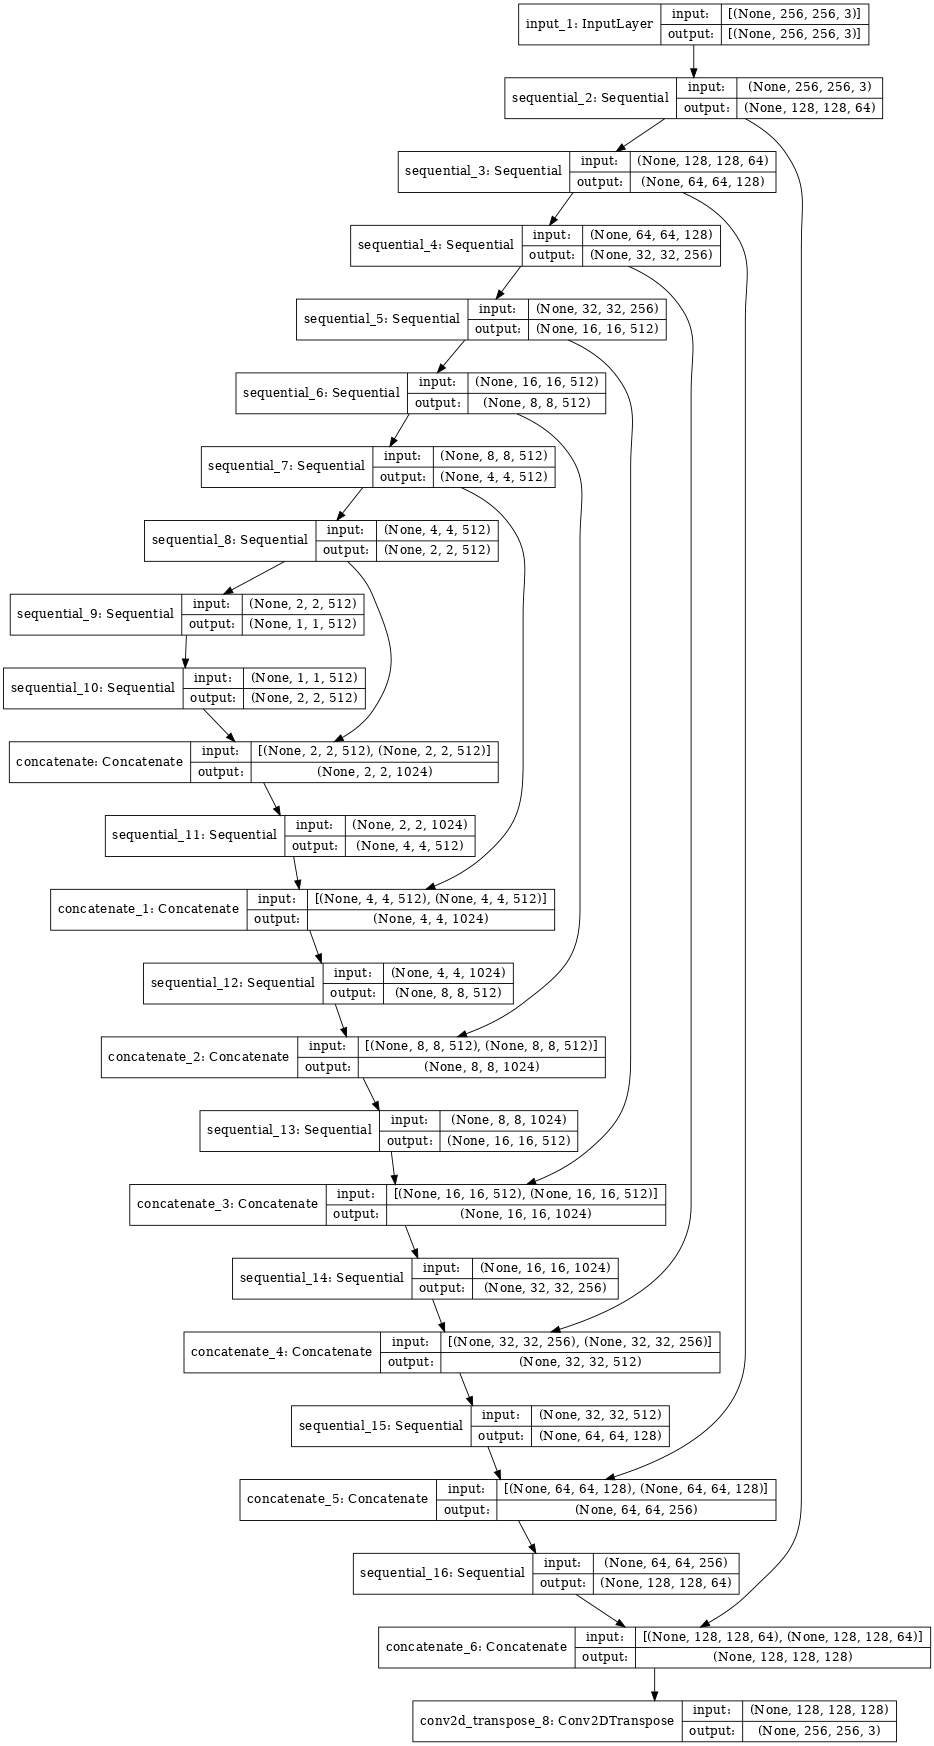

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

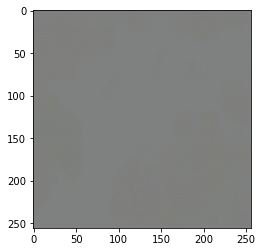

In [23]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [24]:
LAMBDA = 100

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  #LAMBDA=dynamic_lambda(target,gen_output)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [26]:
def Discriminator():
  size=4
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, size, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, size)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, size)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, size, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

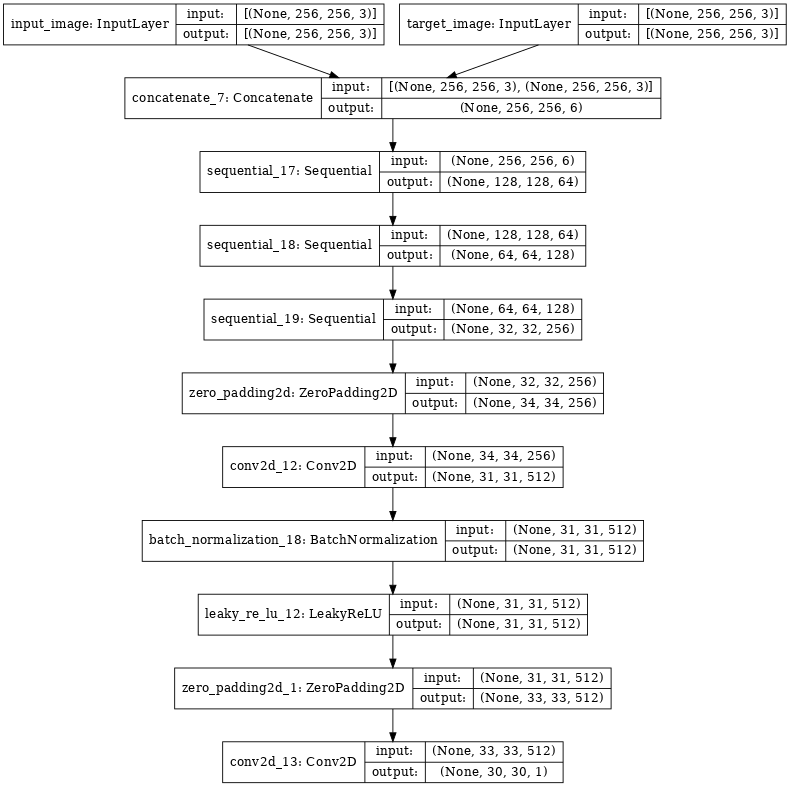

In [27]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

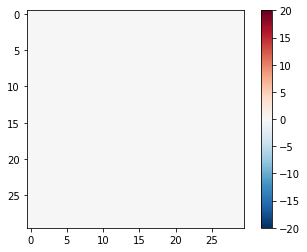

In [28]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
#1-bce-dice

def loss_object_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    l=loss_object1(y_true,y_pred)
    return tf.abs(-l+(numerator / denominator))

In [31]:
def dynamic_lambda(i1,i2):
  
    a=tf.equal(i1,i2)
    b=tf.cast(a,tf.float32)
    
    L=LAMBDA/(0.1+tf.reduce_mean(b))
    tf.print(L, output_stream=sys.stderr)
    return L

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    #print(total_disc_loss)
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [33]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_prefix, max_to_keep=5)

NameError: name 'generator_optimizer' is not defined

In [34]:
#checkpoint.save(file_prefix = checkpoint_prefix)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [35]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ref for style_transfer', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

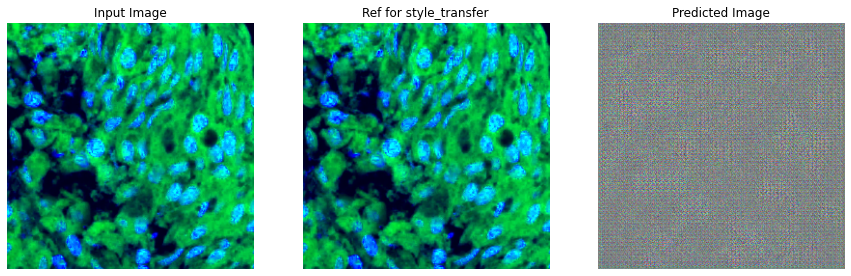

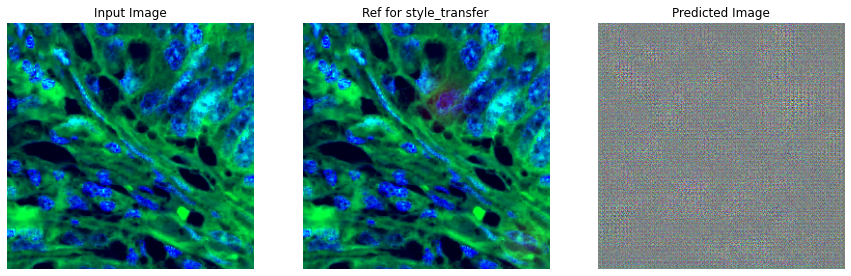

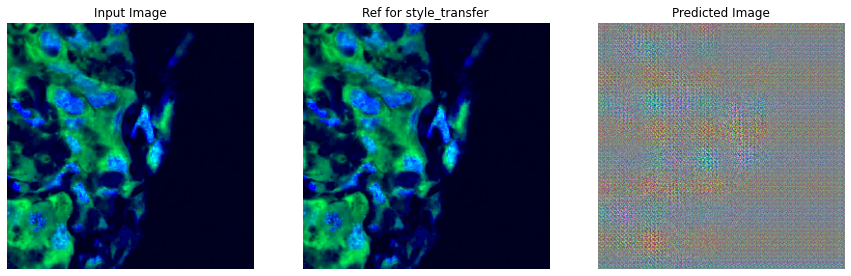

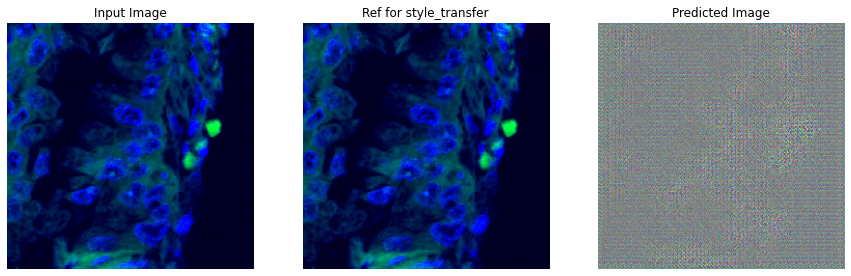

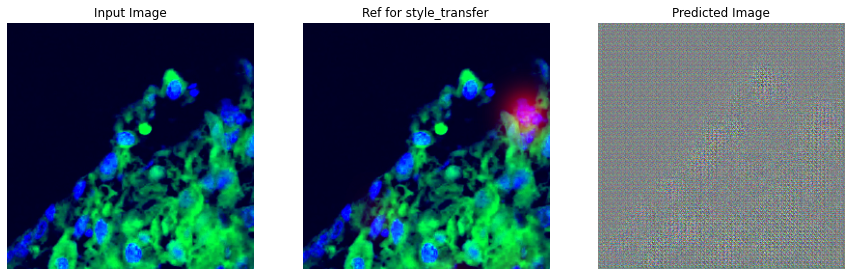

In [36]:
for example_input, example_target in test_dataset.take(5):
    #print("*")
    generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [57]:
EPOCHS = 50

In [58]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [59]:
disc_loss_1=[]
gen_total_loss_1=[]
gen_l1_loss_1=[]
gen_gan_loss_1=[]
psnr=[]
ssim=[]

In [68]:
@tf.function
def train_step(input_image, target, epoch, gen_learning_rate, disc_learning_rate):


  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    ps=tf.reduce_mean(tf.image.psnr(gen_output,target, max_val=1.0))
    #tf.print(ps)
    #psnr.append(ps)
    ss=tf.reduce_mean(tf.image.ssim(gen_output,target, 1.0))
    #ssim.append(ss)
    #tf.print(ss)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  
  generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=0.5)
  discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=0.5)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    tf.summary.scalar('ssim', ss, step=epoch)
    tf.summary.scalar('psnr', ps, step=epoch)
    #print("gen_l1_loss")
    #tf.print(gen_l1_loss, output_stream=sys.stderr)
    #print("gen_gan_loss")
    #tf.print(ss, output_stream=sys.stderr)
    #tf.print(gen_gan_loss, output_stream=sys.stderr)
    #print("disc_loss")
    #tf.print(disc_loss, output_stream=sys.stderr)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,disc_loss,ps,ss

In [72]:
def objective(trial):
    gen_learning_rate = trial.suggest_float("gen_learning_rate", 1e-4, 1e-2, log=True)
    disc_learning_rate = trial.suggest_float("disc_learning_rate", 1e-4, 1e-2, log=True)
  #  beta_1 = trial.suggest_float("beta_1", 0.2, 1.2, log=True)
    epoch = trial.suggest_int("epochs", 50, 150, log=True)

    for n, (input_image, target) in train_dataset.enumerate():
        # Include the hyperparameters in the train_step call
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, ps, ss = train_step(
            input_image, target, epoch, gen_learning_rate, disc_learning_rate
        )

    # Return the metric to be optimized
    return gen_total_loss + gen_gan_loss +  gen_l1_loss +  disc_loss + ps + ss# Change this based on your metric (e.g., PSNR, SSIM)

In [73]:
study = optuna.create_study(direction="minimize")  # or "maximize" based on your metric
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters and the corresponding metric value
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-07 21:41:19,090] A new study created in memory with name: no-name-62fca2da-67e8-4e51-994a-afb88f38785a
[W 2023-12-07 21:41:20,300] Trial 0 failed with parameters: {'gen_learning_rate': 0.0051499930909804734, 'disc_learning_rate': 0.00029672343626091746, 'epochs': 118} because of the following error: ValueError('in user code:\n\n    /tmp/ipykernel_32089/3634485474.py:28 train_step  *\n        generator_optimizer.apply_gradients(zip(generator_gradients,\n    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients  **\n        self._create_all_weights(var_list)\n    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:781 _create_all_weights\n        _ = self.iterations\n    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__\n        return super(

ValueError: in user code:

    /tmp/ipykernel_32089/3634485474.py:28 train_step  *
        generator_optimizer.apply_gradients(zip(generator_gradients,
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients  **
        self._create_all_weights(var_list)
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:781 _create_all_weights
        _ = self.iterations
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:921 iterations
        self._iterations = self.add_weight(
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1122 add_weight
        variable = self._add_variable_with_custom_getter(
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py:805 _add_variable_with_custom_getter
        new_variable = getter(
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:130 make_variable
        return tf_variables.VariableV1(
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:206 _variable_v1_call
        return previous_getter(
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/saab/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:730 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [42]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(3):
            generate_images(generator, example_input, example_target)
        
        print("Epoch: ", epoch)

    # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
   
            train_step(input_image, target, epoch)

    # saving (checkpoint) the model every 5 epochs
                
        manager.save()

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    #checkpoint.save(file_prefix = checkpoint_prefix)

In [43]:
checkpoint_dir

'./training_checkpoints/Oct15_Serial/Dataset1_bs_350_ep_150'

In [44]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))
#generator.load_weights(path_gen)
#discriminator.load_weights(path_dis)

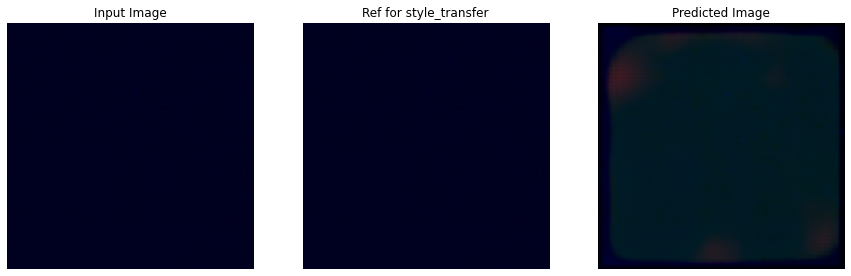

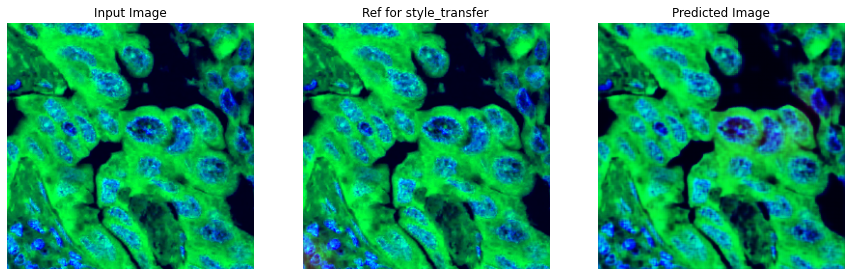

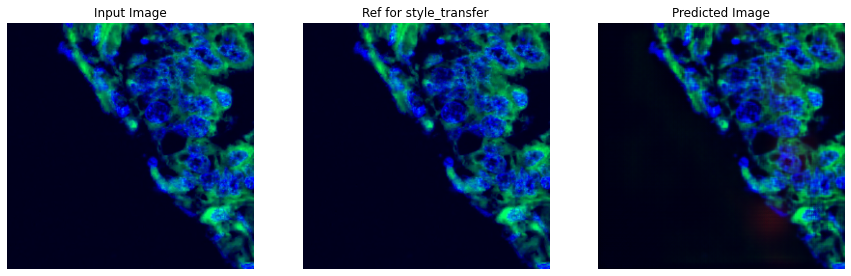

In [45]:
for example_input, example_target in valid_dataset.take(3):
            generate_images(generator, example_input, example_target)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [46]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

Now run the training loop:

In [ ]:
fit(train_dataset, EPOCHS, valid_dataset)

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## CSV files to get shuffled patch indices (Running once is sufficient)

In [ ]:
lst_sort=[]
images = sorted(glob(os.path.join(path, "Images/*")))
for x,y in zip(train_x,images):
    lst_sort.append([x.split("/")[-1],y.split("/")[-1]])

In [ ]:
import pandas as pd
df_lst=pd.DataFrame(lst_sort)

In [ ]:
# Get shuffled patch indices
df_lst.to_csv("/home/saab/Desktop/file_paths_2023.csv")

In [ ]:
lst_sort2=[]
for x in(test_x):
    lst_sort2.append([x.split("/")[-1]])
for x in(valid_x):
    lst_sort2.append([x.split("/")[-1]])
df_lst=pd.DataFrame(lst_sort2)
df_lst.to_csv("/home/saab/Desktop/file_paths_test_2023.csv")

# Asking paths

In [45]:
p_train=filedialog.askdirectory(title='path for train_results')
p_test=filedialog.askdirectory(title='path for test_results')

# Training dataset inference

In [51]:

P_train_gt=os.path.join(p_train,"gt")
P_train_pred=os.path.join(p_train,"pred")
P_train_img=os.path.join(p_train,"img")
os.makedirs(P_train_img,exist_ok=True)
os.makedirs(P_train_gt,exist_ok=True)
os.makedirs(P_train_pred,exist_ok=True)
i=0
for x,y in train_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_train_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_train_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_train_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

KeyboardInterrupt: 

# Testing dataset inference

In [46]:

P_test_gt=os.path.join(p_test,"gt")
P_test_pred=os.path.join(p_test,"pred")
P_test_img=os.path.join(p_test,"img")
os.makedirs(P_test_img,exist_ok=True)
os.makedirs(P_test_pred,exist_ok=True)
os.makedirs(P_test_gt,exist_ok=True)
i=0
for x,y in test_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1
for x,y in valid_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [ ]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
len(st)

In [ ]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

In [ ]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

In [ ]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_valid(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

# Extra code

In [ ]:
#!pip install pandas
import pandas as pd



In [ ]:
images = sorted(glob(os.path.join(path, "images/*")))
masks = sorted(glob(os.path.join(path, "masks/*")))


In [ ]:
green = np.zeros([256,256,3],dtype=np.float32)
green[:]=(0,225,0)
green=green/127.5-1

In [ ]:
ind_ssim=[]
numbers=[]
for i in range(len(images)):
    print(i)
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    ss=tf.reduce_mean(tf.image.ssim(v,np.expand_dims(b,axis=0), 1.0))
    #gre=tf.reduce_mean(tf.math.sqrt(tf.abs(tf.math.square(green)-tf.math.square(v[0]))))
    img=v[0]*0.5+0.5
    plt.imshow(img.numpy())
    #tf.print(gre)
    
    ind_ssim.append((ss.numpy(),i))

    #img=np.asarray(v[0]*0.5+0.5,np.uint8)

In [ ]:
ind_ssim.sort()

In [ ]:
max(ind_ssim)

In [ ]:
ssim3=[]
for x in ind_ssim:
    ssim3.append(x[1])

In [ ]:

df_ssim_3=pd.DataFrame({"old_numbers":ssim3})

In [ ]:
df_ssim_3

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:

df_ssim_3=pd.read_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")
path_to_store=os.getcwd()+"/ans_cd3_new/"+date+"/"+mask+"/"
p1=os.path.join(path_to_store,"sorted")
p2=os.path.join(path_to_store,"unsorted")
p3=os.path.join(path_to_store,"sorted_gt")
p4=os.path.join(path_to_store,"unsorted_gt")
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
os.makedirs(p4,exist_ok=True)

In [ ]:
ssim3=df_ssim_3["old_numbers"].tolist()

In [ ]:
ssim3

In [ ]:
x=0
for i in (ssim3):
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    img2=b*0.5+0.5
    #plt.figure()
    #plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    
    plt.imsave(p1+"/"+f"{x:06d}"+".png",img.numpy())
    plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    plt.imsave(p3+"/"+f"{x:06d}"+".png",img2.numpy())
    plt.imsave(p4+"/"+f"{i:06d}"+".png",img2.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
b_test=glob(os.getcwd()+"/gt/*.png")
p099=os.getcwd()+"/new_test_dataset_results"+date
os.makedirs(p099,exist_ok=True)
x=0
for i in (b_test):
    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    #img2=b*0.5+0.5
    plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    plt.imsave(p099+"/"+f"{x:06d}"+".png",img.numpy())
    #plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:
os.getcwd()+"/old_nos_new_test"+date+".csv"

In [ ]:
new_test_path="/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles"
test_imgs_cptac=sorted(glob(new_test_path+"/*.png"))
len(test_imgs_cptac)

In [ ]:
x=0
test_predict=sorted(glob("/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/*"))
test_predict

In [ ]:
tpi=os.getcwd()+"/predict_hcc1_2"
os.makedirs(tpi,exist_ok=True)
for i in test_predict:

    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5

    plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())

    print(x,end=" ")
    x=x+1

In [ ]:
for tp in test_predict:
    x=0
    tpi=tp+"/predict"
    os.makedirs(tpi,exist_ok=True)
    test_imgs_cptac=sorted(glob(tp+"/small_tiles/*"))
    for i in (test_imgs_cptac):
        a=load(i,condtn=False)
        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5
    
        plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())
    
        print(x,end=" ")
        x=x+1
    print(" ")

In [ ]:
test_y

In [ ]:
p1=filedialog.askdirectory(title='path for unsorted_gt')
print(len(glob(p1+"/*.png")))
p2=filedialog.askdirectory(title='path for unsorted_pred')
print(len(glob(p2+"/*.png")))

In [ ]:
for x in test_y:
    os.remove(p1+"/"+x.split("/")[-1])
    os.remove(p2+"/"+x.split("/")[-1])

In [ ]:
print(len(glob(p1+"/*.png")))
print(len(glob(p2+"/*.png")))

In [ ]:
a.shape